In [67]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Import Local funcs
import sys
sys.path.append('../')
from utils.utils import *

# Import Data

In [53]:
X, y = get_training()


In [54]:
# Drop Object Columns
X_obj_dropped = X.select_dtypes(exclude=['object'])

In [55]:
# OR, colnames of categorical columns
categoricals = X.select_dtypes('object').columns
indexes_of_categories = [X.columns.get_loc(col) for col in categoricals]

In [56]:
# Convert categorical columns to integers - For Boosting
X_encoded = X.copy()
for col in categoricals:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes


In [57]:
# Make Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

# 01 - Naive LGB

In [27]:
# Naive LGBM

# If dropped categoricals
clf_naive = lgb.LGBMClassifier()
clf_naive.fit(X_train, y_train)

# OR, If including categoricals
#fit_params = {'categorical_feature':indexes_of_categories}
#clf_naive = lgb.LGBMClassifier()
#clf_naive.fit(X_train, y_train, fit_params)


LGBMClassifier()

In [28]:
# Evaluate Train Accuracy
y_pred_train = clf_naive.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.79


In [29]:
# Evaluate Test Accuracy
y_pred_test = clf_naive.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.64


In [69]:
# Evaluate MultiLogLoss
y_pred_proba = clf_naive.predict_proba(X_test)
multi_log_loss = log_loss(y_test, y_pred_proba)
print(f'Multi Log Loss: {multi_log_loss:.4f}')

Multi Log Loss: 0.8598


# 02 - Some Tuning

In [58]:
# Prepare lbg dataset
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test, reference=d_train)

In [60]:
# Train Model
params = {
    "num_leaves": 10,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    "learning_rate": 0.01,
    "objective": "multiclass",
    "boost_from_average": True,
    "early_stopping_round": 50,
    "num_class" : 5
}

model = lgb.train(
    params,
    d_train,
    num_boost_round=10000,
    valid_sets=d_test,
    categorical_feature=indexes_of_categories,
)

/Users/zaza/miniconda3/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 290, 294, 297, 340, 420, 421, 434]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9204
[LightGBM] [Info] Number of data points in the train set: 33600, number of used features: 428


/Users/zaza/miniconda3/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/zaza/miniconda3/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score -4.282397
[LightGBM] [Info] Start training from score -1.579677
[LightGBM] [Info] Start training from score -1.216351
[LightGBM] [Info] Start training from score -1.261657
[LightGBM] [Info] Start training from score -1.606169
[1]	valid_0's multi_logloss: 1.41897
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.41043
[3]	valid_0's multi_logloss: 1.40254
[4]	valid_0's multi_logloss: 1.39425
[5]	valid_0's multi_logloss: 1.38669
[6]	valid_0's multi_logloss: 1.37914
[7]	valid_0's multi_logloss: 1.37196
[8]	valid_0's multi_logloss: 1.36464
[9]	valid_0's multi_logloss: 1.35791
[10]	valid_0's multi_logloss: 1.35089
[11]	valid_0's multi_logloss: 1.34429
[12]	valid_0's multi_logloss: 1.33768
[13]	valid_0's multi_logloss: 1.33116
[14]	valid_0's multi_logloss: 1.32476
[15]	valid_0's multi_logloss: 1.31869
[16]	valid_0's multi_logloss: 1.31266
[17]	valid_0's multi_logloss: 1.30692
[18]	valid_0's multi_logloss: 1.

In [9]:
# Evaluate Train Accuracy
y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: {train_accuracy:.2f}')

Train Accuracy: 0.74


In [10]:
# Evaluate Test Accuracy
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
train_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {train_accuracy:.2f}')

Test Accuracy: 0.64


In [72]:
# Evaluate MultiLogLoss on Test Set
y_pred_proba = model.predict(X_test)
multi_log_loss = log_loss(y_test, y_pred_proba)
print(f'Multi Log Loss: {multi_log_loss:.5f}')

Multi Log Loss: 0.85937


In [64]:
# CV Log Loss
cv_results = lgb.cv(
    params,
    d_train,
    num_boost_round=10000,
    nfold=5,
    stratified=False,
    categorical_feature = indexes_of_categories,
)

print(f'CV: Multi Log Loss: {cv_results['multi_logloss-mean'][-1]:.5f}')


0.8588997056216325

# Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

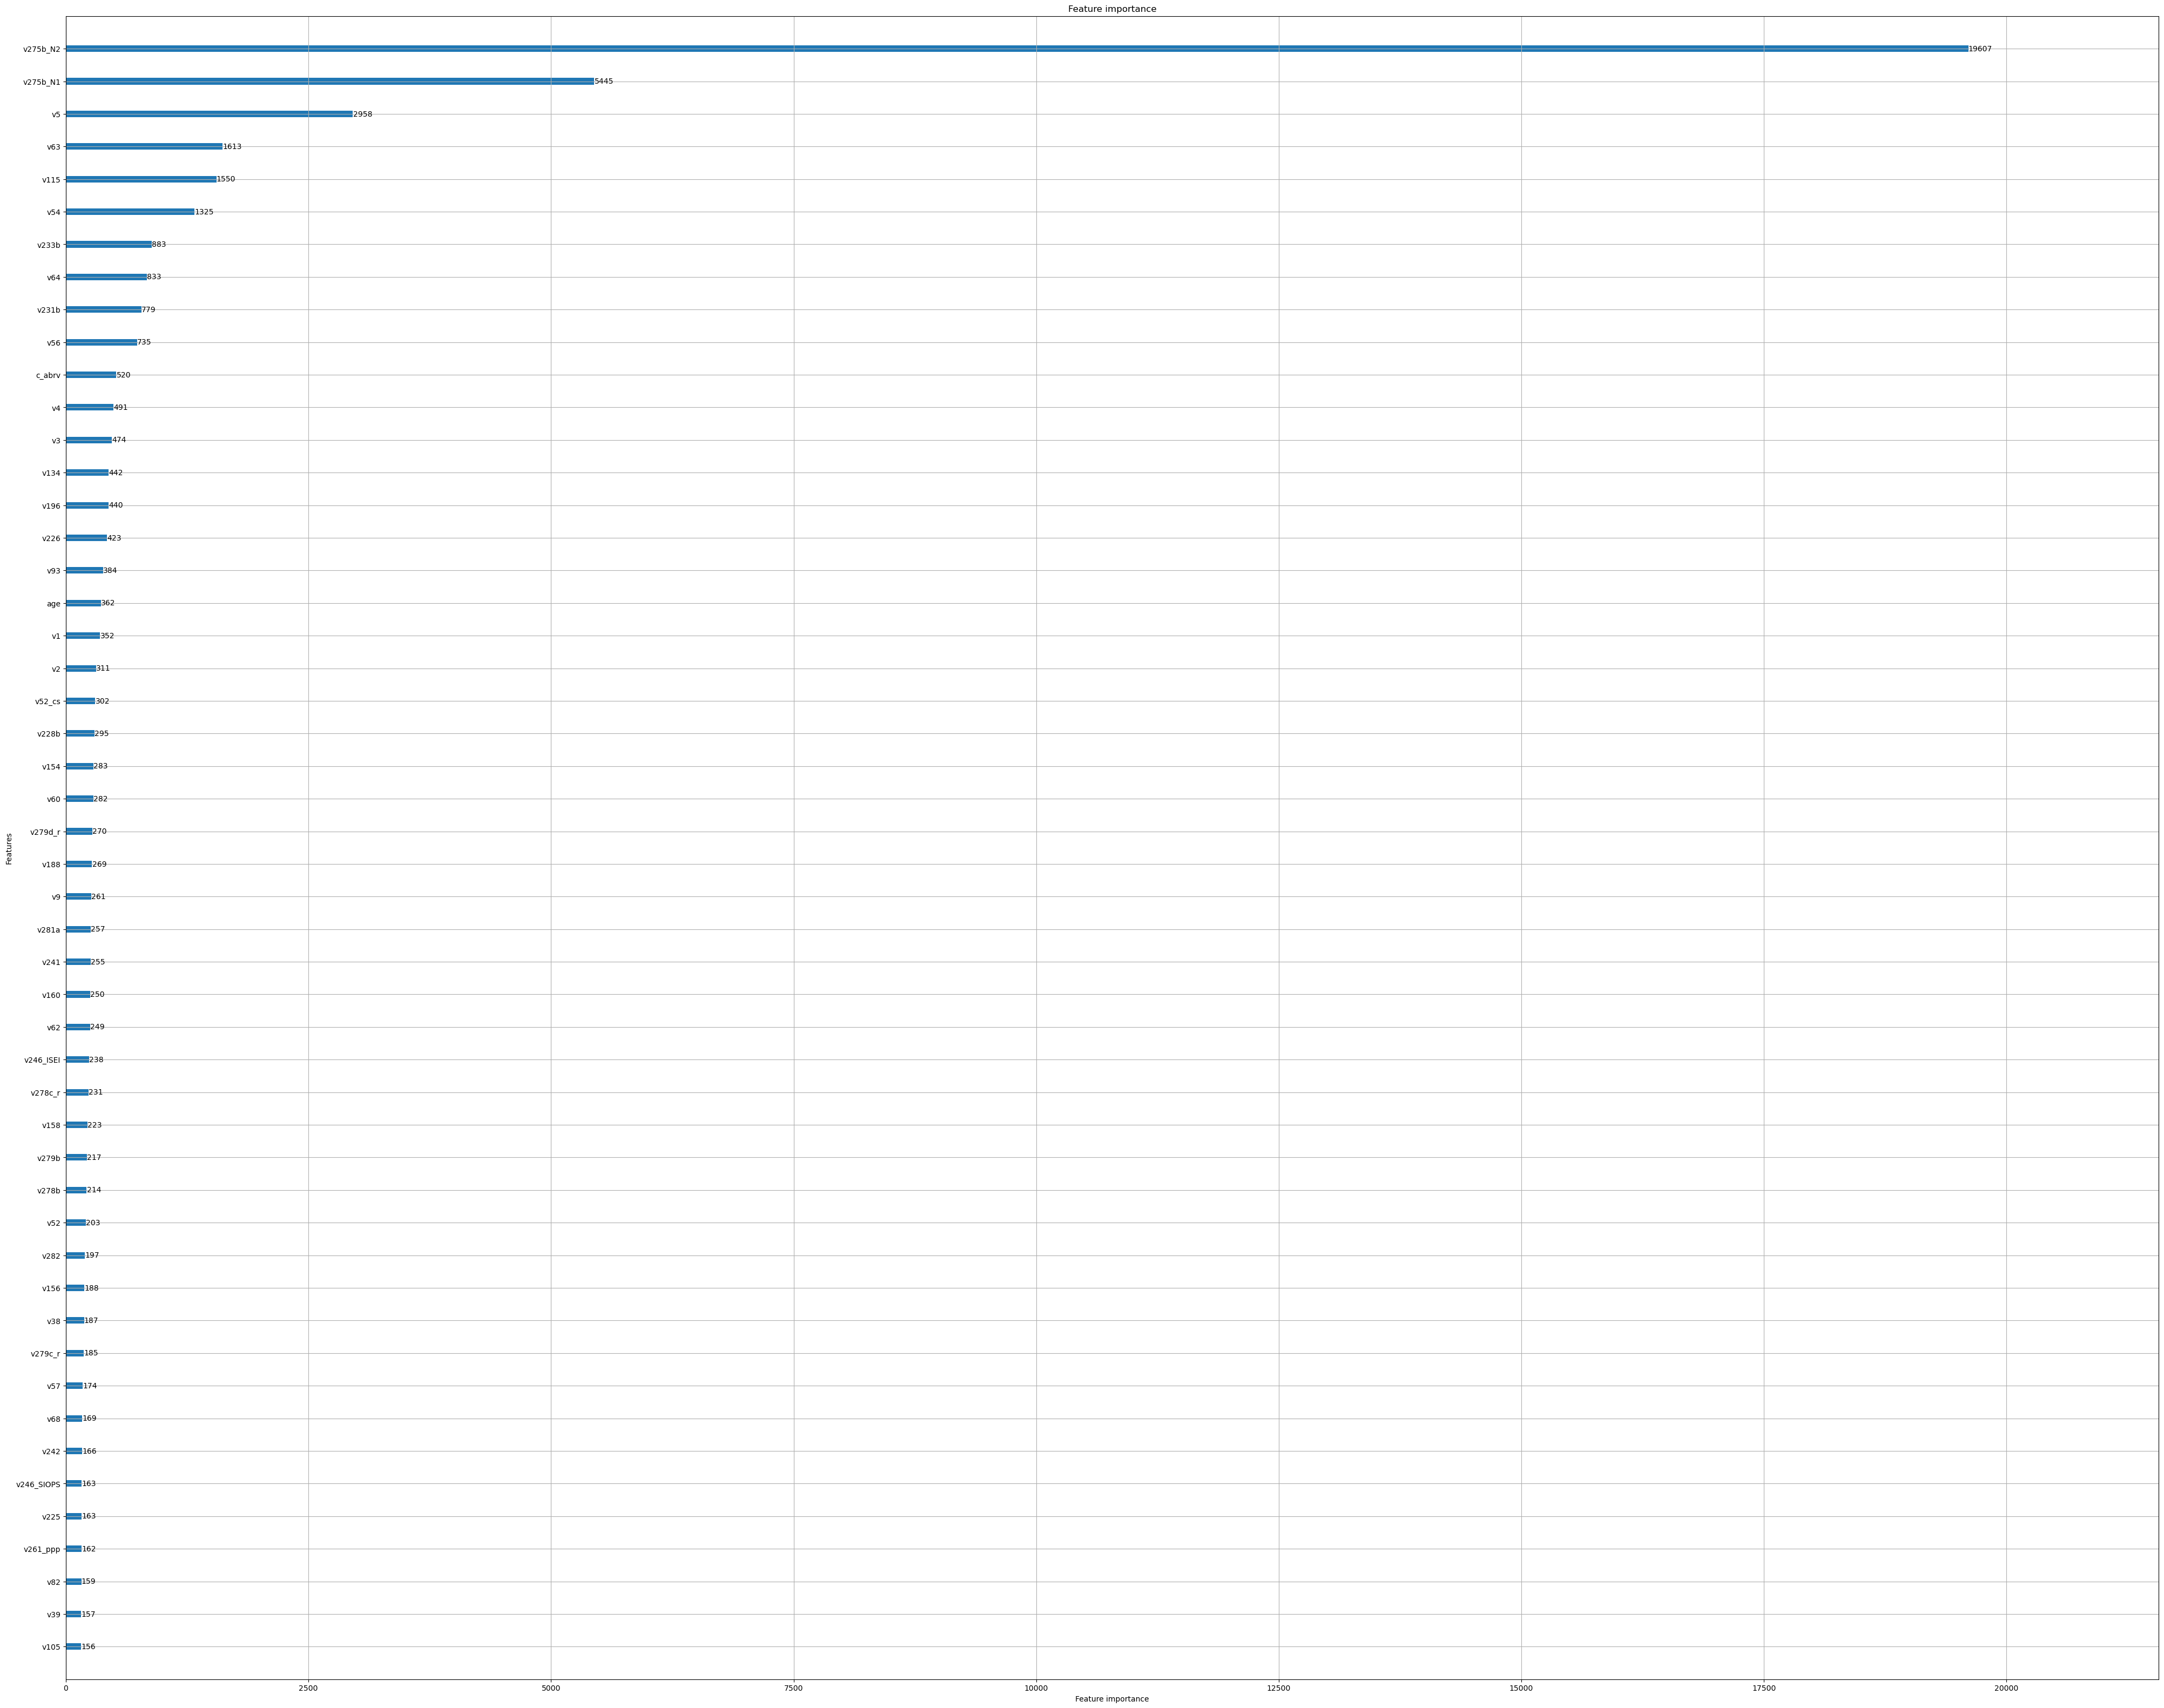

In [65]:
lgb.plot_importance(model, max_num_features=50, figsize=(50,40))

# Submission

In [19]:
# Train Model on Full Data
params = {
    "num_leaves": 10,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,                
    "learning_rate": 0.05,
    "objective": "multiclass",
    "boost_from_average": True,
    "num_class" : 5,
}

final_model = lgb.LGBMCl(**params)
final_model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8444
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 420
[LightGBM] [

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, boost_from_average=True,
              feature_fraction=0.8, learning_rate=0.05, metric='multi_logloss',
              num_class=5, num_leaves=10, objective='multiclass')

In [20]:
predictions = final_model.predict(X_test_subm)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [21]:
# Make a df of preds
preds_df = pd.DataFrame(predictions, columns=['no answer', 'very important', 'quite important', 'not important', 'not at all important'])
preds_df.index.name = 'id'
print(preds_df.shape)
preds_df.head()

(11438, 5)


,no answer,very important,quite important,not important,not at all important
id,,,,,
0,0.003306,0.624920,0.180274,0.150321,0.041179
1,0.008152,0.114442,0.751024,0.110637,0.015745
2,0.015958,0.196130,0.386632,0.356443,0.044838
3,0.013057,0.159865,0.586740,0.187066,0.053272
4,0.006788,0.311724,0.545037,0.114975,0.021477


In [22]:
# Save to CSV
preds_df.to_csv('../data/predictions2.csv')
